# Garch(1,1)

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize
import yfinance as yf
import inspect

# local files
from garch11 import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demos
get historical data from yahoo finance

In [16]:
ticker = r'^GSPC'
period = ['1990-01-01','2020-05-31']
df = yf.download(ticker.upper(), period[0], period[1])


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

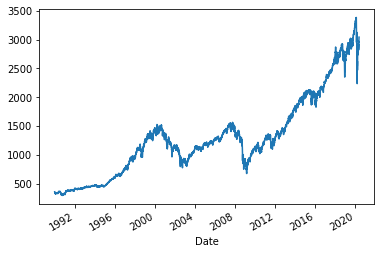

In [17]:
# data to work with
s_ts = df['Adj Close']
# quick view
plt.figure()
s_ts.plot()

# Garch filter
run a garch filter with assumed beta & gamma parameters
e.g. $\beta = 0.94$ and $\gamma=0.05$

In [18]:
# show local functions
print(inspect.getsource(garch_filter))

def garch_filter(beta, gamma, v_r, mu, sigma2_inf, sigma2_0):
    '''
    input:
    beta, gamma: garch(1,1) beta & gamma
    v_r: historical return
    mu: drift
    sigma2_inf: sigma_inf squared squared
    sigma2_0: the initial sigma squared
    
    output: dictionary of
    eps: vector of residuals
    sigma2: vector of sigma squared
    sigma2_next: next sigma squared
    '''
    
    alpha = sigma2_inf * (1 - beta - gamma)
    v_eps = np.ones_like(v_r)
    v_sigma2 = np.ones_like(v_r)

    sigma2_nxt = sigma2_0

    for n in range(len(v_r)):
        v_sigma2[n] = sigma2_nxt
        v_eps[n] = (v_r[n] - mu)/np.sqrt(sigma2_nxt)
        sigma2_nxt = alpha + beta * v_sigma2[n] + gamma * v_sigma2[n] * (v_eps[n]**2)
    
    return {'eps':v_eps, 'sigma2':v_sigma2, 'sigma2_next':sigma2_nxt}



In [19]:
# daily log difference
diff_period = 1
s_r = np.log(s_ts).diff(periods=diff_period)
s_r = s_r.dropna()

# set mu and sigma_inf (using all data available)
# we can use these the starting value
mu = s_r.mean()
sigma_inf = s_r.std()
print('mu, sigma_inf')
mu, sigma_inf

mu, sigma_inf


(0.00027878697514298974, 0.011485703136888086)

In [78]:
# set the parameters & run the filter
beta = 0.9
gamma = 0.09
sigma2_0 = sigma_inf**2
kw_g11 = garch_filter(beta, gamma, s_r.values, mu, sigma_inf**2, sigma2_0)

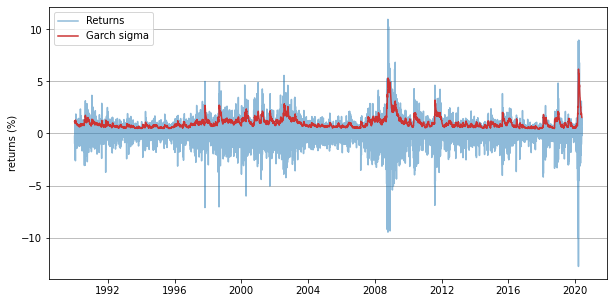

In [79]:
# plots
toperc = 100
df_p = pd.DataFrame(data=s_r.values, index=s_r.index, columns=['Return'])
v_dt = s_r.index
v_garch_sig_scaled = np.sqrt(kw_g11['sigma2'])
plt.figure(figsize=[10,5])
plt.plot(v_dt, toperc * s_r, alpha = 0.5, label='Returns')
plt.plot(v_dt, toperc * v_garch_sig_scaled, c=[0.8,0.2,0.2], label='Garch sigma')
#plt.plot(v_dt, toperc * (-1) * v_garch_sig_scaled, c=[0.8,0.2,0.2], label='neg of garch sigma')
plt.legend()
plt.grid(axis='y')
plt.ylabel('returns (%)')
plt.savefig('returns.png')
plt.show()

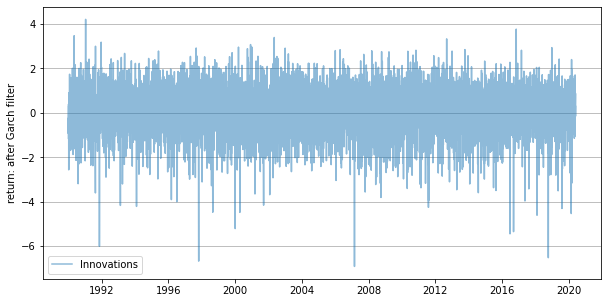

In [80]:
# plots
v_garch_sig_scaled = np.sqrt(kw_g11['sigma2'])
plt.figure(figsize=[10,5])
plt.plot(v_dt, kw_g11['eps'], alpha = 0.5, label='Innovations')
plt.legend()
plt.grid(axis='y')
plt.ylabel('return: after Garch filter')
plt.savefig('innovations.png')
plt.show()

# Simulation

Generate the innovation term and simulate. 

In [81]:
#v_eps = kw_g11['eps'] # to check. the original return should be reproduced

# using standard normal
v_eps = np.random.standard_normal(v_dt.size)
kw_r_sim_garch = garch_return_simulation(beta, gamma, mu, sigma_inf**2, sigma2_0, v_eps)
kw_r_sim_normal = garch_return_simulation(0.0, 0.0, mu, sigma_inf**2, sigma2_0, v_eps)

# actual time series
v_sim_garch = np.exp(np.hstack((0.0, np.cumsum(kw_r_sim_garch['r']))))
v_sim_normal = np.exp(np.hstack((0.0, np.cumsum(kw_r_sim_normal['r']))))

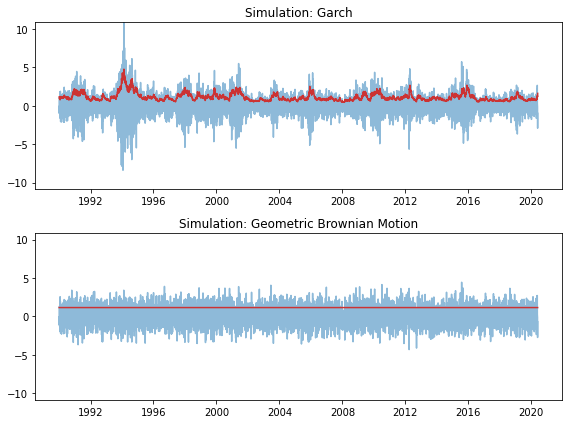

In [82]:
toperc = 100
v_r_max = np.max(np.abs(kw_r_sim_garch['r']))
v_ylim = toperc * np.array([-v_r_max, v_r_max])
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.plot(v_dt, toperc * kw_r_sim_garch['r'], alpha = 0.5, label='return')
plt.plot(v_dt, toperc * np.sqrt(kw_r_sim_garch['sigma2']), c=[0.8,0.2,0.2], label='Garch sigma')
plt.ylim(v_ylim)
plt.title('Simulation: Garch')
plt.subplot(2,1,2)
plt.plot(v_dt, toperc * kw_r_sim_normal['r'], alpha = 0.5, label='return')
plt.plot(v_dt, toperc * np.sqrt(kw_r_sim_normal['sigma2']), c=[0.8,0.2,0.2], label='Garch sigma')
plt.ylim(v_ylim)
plt.title('Simulation: Geometric Brownian Motion')
plt.tight_layout()
plt.savefig('simulation.png')
plt.show()

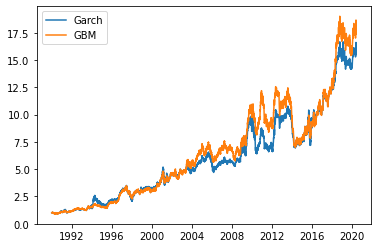

In [83]:

plt.figure()
plt.plot(s_ts.index, v_sim_garch, label = 'Garch')
plt.plot(s_ts.index, v_sim_normal, label = 'GBM')
plt.legend()
plt.savefig('simulation-level.png')
plt.show()


# MLE

In [26]:
# mle function
print(inspect.getsource(garch_mle_obj))

def garch_mle_obj(v_r, mu, v_sigma2):
    return - np.sum(np.log(v_sigma2) + (v_r-mu)**2/v_sigma2)



## Manual scan

In [27]:
v_beta = np.linspace(0.8, 0.99, 50)
v_gamma = np.linspace(0.01, 0.2, 50)
mtx_beta, mtx_gamma = np.meshgrid(v_beta, v_gamma)
mtx_mle = np.zeros_like(mtx_beta)

In [28]:
v_r = s_r.values
sum_l = 0.90
sum_u = 0.9999

for ib in range(v_beta.size):
    if ib % 5 == 0:
        print('progress: ' + str(100 * ib/v_beta.size) + '%')
        
    for ig in range(v_gamma.size):
        beta_i = mtx_beta[ig, ib]
        gamma_i = mtx_gamma[ig, ib]
        if (beta_i + gamma_i >= sum_u) | (beta_i + gamma_i <= sum_l):
            mtx_mle[ig, ib] = np.nan
        else:
            kw_i = garch_filter(beta_i, gamma_i, v_r, mu, sigma_inf**2, sigma_inf**2)
            mo = garch_mle_obj(v_r, mu, v_sigma2=kw_i['sigma2'])
            mtx_mle[ig, ib] = mo
print('done')

progress: 0.0%
progress: 10.0%
progress: 20.0%
progress: 30.0%
progress: 40.0%
progress: 50.0%
progress: 60.0%
progress: 70.0%
progress: 80.0%
progress: 90.0%
done


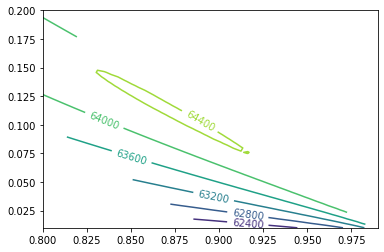

In [29]:
fig, ax = plt.subplots()
CS = ax.contour(mtx_beta, mtx_gamma, mtx_mle)
ax.clabel(CS, inline=1, fontsize=10)
plt.savefig('mle-contour.png')
plt.show()

## Optimization

In [30]:
# minimisation function
def mle_obj_neg(bg):
    # bake in boundary condition
    min_gap = 0.00001

    # calc
    beta = np.minimum(bg[0], 1.0 - min_gap)
    gamma = np.minimum(bg[1], (1-beta) - min_gap)
    kw = garch_filter(beta, gamma, v_r, mu, sigma_inf**2, sigma_inf**2)
    return - garch_mle_obj(v_r, mu, v_sigma2=kw['sigma2'])

In [31]:
res = scipy.optimize.minimize(mle_obj_neg, [0.8,0.10], method='nelder-mead', options={'xatol':1.0e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: -64432.002198
         Iterations: 45
         Function evaluations: 88


In [32]:
# results
res.x

array([0.88035162, 0.10633708])

# Expected variance

In [85]:
v_tau = np.array([1, 2, 5, 10, 20, 60, 120, 240, 2*240, 5*240, 10*240, 20*240, 30*240, 50* 240])
sigma2_inf = sigma_inf**2
v_sigma2_1 = sigma2_inf * np.array([0.5, 0.75, 1.0, 1.25, 1.5])

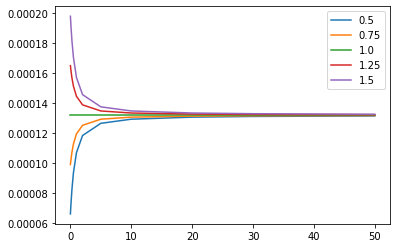

In [61]:
plt.figure()
for sigma2_1 in v_sigma2_1:
    v_sigma2_exp = garch_exp_variance(sigma2_1, sigma2_inf, beta, gamma, v_tau)
    plt.plot(v_tau/240, v_sigma2_exp, label=str(sigma2_1/sigma2_inf))
plt.legend()
plt.show()

[]

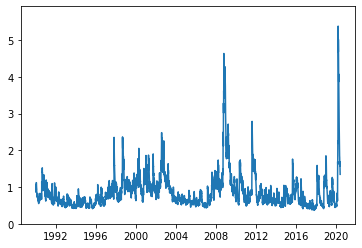

In [63]:
# plot the ratio
plt.figure()
v_sigma_ratio = v_garch_sig_scaled/sigma_inf
plt.plot(s_r.index, v_sigma_ratio)
plt.ylim([0, np.max(v_sigma_ratio)*1.1])
plt.plot()

# END